## Importar las librerías necesarias para realizar los análisis

In [111]:
# Para cargar las variables de entorno
from dotenv import load_dotenv

# Para conectar a la base de datos en PostgreSQL
from sqlalchemy import create_engine

# Para manejar variables del sistema
import os

# Para realizar análisis de datos
import pandas as pd
from sklearn.cluster import KMeans

# Para visualización de gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Para realizar operaciones numéricas
import numpy as np

## Conexión a la base de datos
### Se usa un archivo de texto que contiene las variables de entorno que se requieren para lograr la conexión y así se garantiza la seguridad de las credenciales de acceso a la base de datos

In [ ]:
# Cargar las variables desde el archivo .env
load_dotenv('.env')

# Obtener las credenciales desde las variables de entorno
username = os.getenv('DB_USERNAME')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')
database = os.getenv('DB_NAME')

# Configuración de la conexión a PostgreSQL
engine = create_engine(f'postgresql://{username}:{password}@{host}:{port}/{database}')

# Verificar la conexión ejecutando una consulta simple
df = pd.read_sql_query("select now();", engine)
print(df)

In [113]:
# Leer datos de las tablas y cargarlos en los dataframes
cliente_df = pd.read_sql('select * from cliente', engine)
categoria_df = pd.read_sql('select * from categoria', engine)
producto_df = pd.read_sql('select * from producto', engine)
region_df = pd.read_sql('select * from region', engine)
venta_df = pd.read_sql('select * from venta', engine)
venta_detalle_df = pd.read_sql('select * from venta_detalle', engine)

### Estadísticas descriptivas básicas
El método describe() proporciona un resumen estadístico que incluye: 
- count: El número de valores no nulos 
- mean: La media (promedio) de los valores 
- std: La desviación estándar de los valores 
- min: El valor mínimo 
- 25%: El percentil 25 (primer cuartil) 
- 50%: La mediana (percentil 50 o segundo cuartil) 
- 75%: El percentil 75 (tercer cuartil) 
- max: El valor máximo

### Estas estadísticas proporcionan una visión detallada de las cantidades de productos vendidos, lo que permite comprender mejor los patrones de venta y detectar posibles anomalías

In [114]:
venta_detalle_df[['cantidad']].describe().round(2)

,cantidad
count,1000.00
mean,4.94
std,2.58
min,1.00
25%,3.00
50%,5.00
75%,7.00
max,9.00


### Este análisis proporciona un resumen estadístico sobre los montos totales de las ventas. Ayuda a identificar los montos totales generados, permitiendo evaluar el rendimiento financiero de las ventas

In [115]:
venta_detalle_df[['total']].describe().round(2)

,total
count,1000.00
mean,4600.80
std,3886.51
min,36.84
25%,1477.99
50%,3556.48
75%,6937.80
max,17767.71


## Resumen de Ventas Totales y Transacciones
### Se unen los datos de los dataframes venta_df y venta_detalle_df para obtener una vista completa de las ventas. Luego, se calcula la cantidad total de ventas (número de transacciones) y el monto total de ventas.

In [128]:
# Unir los dataframes venta_df y venta_detalle_df
ventas_completas = venta_df.merge(venta_detalle_df, on='venta_id')

# Calcular la cantidad total de ventas (número de transacciones)
cantidad_ventas = ventas_completas['venta_id'].nunique()

# Calcular el monto total de ventas
total_ventas = ventas_completas['total'].sum()

# Imprimir el resumen de ventas
print(f"Cantidad total de ventas: {cantidad_ventas}")
print(f"Monto total de ventas: ${total_ventas:,.2f}")

Cantidad total de ventas: 1000
Monto total de ventas: $4,600,795.36


## Resumen de Ventas por Región
### Se unen los datos de ventas_completas y region_df para obtener una vista combinada de las ventas por región. Luego, se calculan la cantidad total de ventas y el monto total de ventas por región.

In [129]:
# Unir los datos de ventas_completas y región_df
ventas_por_region = ventas_completas.merge(region_df, on='region_id')

# Calcular la cantidad total de ventas (número de transacciones) por región
cantidad_ventas_region = ventas_por_region.groupby('nombre_region')['venta_id'].nunique()

# Calcular el monto total de ventas por región
total_ventas_region = ventas_por_region.groupby('nombre_region')['total'].sum()

# Función para formatear los valores en millones (M) con separadores de miles
def format_M(x):
    return f"{x / 1_000_000:,.2f}M"

# Aplicar formato a los montos de ventas
total_ventas_region = total_ventas_region.apply(format_M)

print("Cantidad de ventas por región:")
print(cantidad_ventas_region)
print("\nMonto total de ventas por región (en miles):")
print((total_ventas_region))

Cantidad de ventas por región:
nombre_region
Este     258
Norte    240
Oeste    259
Sur      243
Name: venta_id, dtype: int64

Monto total de ventas por región (en miles):
nombre_region
Este     1.32M
Norte    1.22M
Oeste    1.05M
Sur      1.01M
Name: total, dtype: object


## Resumen de Ventas por Categoría
### Se realizan una serie de uniones (merge) entre los dataframes venta_df, venta_detalle_df, producto_df y categoria_df para obtener una vista combinada de las ventas. Luego, se calculan la cantidad total de ventas y el monto total de ventas por categoría.

In [130]:
# Unir los dataframes venta_df y venta_detalle_df
ventas_completas = venta_df.merge(venta_detalle_df, on='venta_id', how='inner')

# Unificar la columna 'producto_id'
ventas_completas['producto_id'] = ventas_completas['producto_id_y']
ventas_completas.drop(['producto_id_x', 'producto_id_y'], axis=1, inplace=True)

# Unir con el dataframe producto_df
ventas_productos = ventas_completas.merge(producto_df, on='producto_id', how='inner')

# Corregir la columna 'categoria_id'
ventas_productos['categoria_id'] = ventas_productos['categoria_id_y']
ventas_productos.drop(['categoria_id_x', 'categoria_id_y'], axis=1, inplace=True)

# Unir con el dataframe categoria_df
ventas_categorias = ventas_productos.merge(categoria_df, on='categoria_id', how='inner')

# Calcular la cantidad total de ventas por categoría (número de transacciones)
cantidad_ventas_categoria = ventas_categorias.groupby('nombre_categoria')['venta_id'].nunique()

# Calcular el monto total de ventas por categoría
total_ventas_categoria = ventas_categorias.groupby('nombre_categoria')['total'].sum()

print("\nCantidad de ventas por categoría:")
print(cantidad_ventas_categoria)

print("\nTotal de ventas por categoría (en miles):")
print((total_ventas_categoria / 1e3).round(2))


Cantidad de ventas por categoría:
nombre_categoria
Electrónica    287
Hogar          296
Juguetería     294
Periféricos    123
Name: venta_id, dtype: int64

Total de ventas por categoría (en miles):
nombre_categoria
Electrónica    1159.38
Hogar          1479.79
Juguetería     1326.23
Periféricos     635.40
Name: total, dtype: float64


## Visualizaciones

### Comportamiento de clientes - Clientes con mayor monto total de compras en la tienda
#### Este análisis utiliza los datos almacenados en los datagrames venta_detalle_df, venta_df y cliente_df para combinar información sobre ventas y clientes. Se calculan y obtienen métricas como la cantidad de ventas y el total de compras, agrupadas por cliente. Esto permite identificar a los clientes que realizan las mayores compraas en términos de valor total, proporcionando una visión clara de los patrones de compra y el comportamiento de los clientes.

In [116]:
# Unir venta_detalle_df con venta_df y cliente_df para obtener información del cliente
venta_detalle_cliente = (venta_detalle_df.merge(venta_df, on='venta_id').merge(cliente_df, on='cliente_id'))

# Agrupar por cliente y calcular métricas
venta_detalle_cliente = (venta_detalle_cliente
                    .groupby(['cliente_id', 'nombre_cliente'])
                    .agg(cantidad_ventas=('venta_id', 'count'),total_ventas=('total', 'sum'))
                    .sort_values(by='total_ventas', ascending=False) 
                    .reset_index())
venta_detalle_cliente = venta_detalle_cliente.drop(columns=['cliente_id']).head(10)
venta_detalle_cliente.index = range(1,11)
print(venta_detalle_cliente)

   nombre_cliente  cantidad_ventas  total_ventas
1      Cliente 43               17     110127.57
2      Cliente 63               16      94780.25
3       Cliente 5               15      85356.86
4      Cliente 70               18      82935.08
5      Cliente 30               13      81736.62
6      Cliente 95               14      81139.11
7      Cliente 24               17      75599.88
8      Cliente 58               11      75347.86
9      Cliente 75               12      72330.36
10     Cliente 98               10      71991.52


## Análisis Temporal de Ventas
### Se analiza el comportamiento de las ventas a lo largo del tiempo utilizando los dataframes venta_df y venta_detalle_df, que contienen registros detallados de las transacciones realizadas. La gráfica resultante muestra el total de ventas mensuales, lo cual permite identificar patrones de ventas y evaluar el rendimiento a lo largo del tiempo.

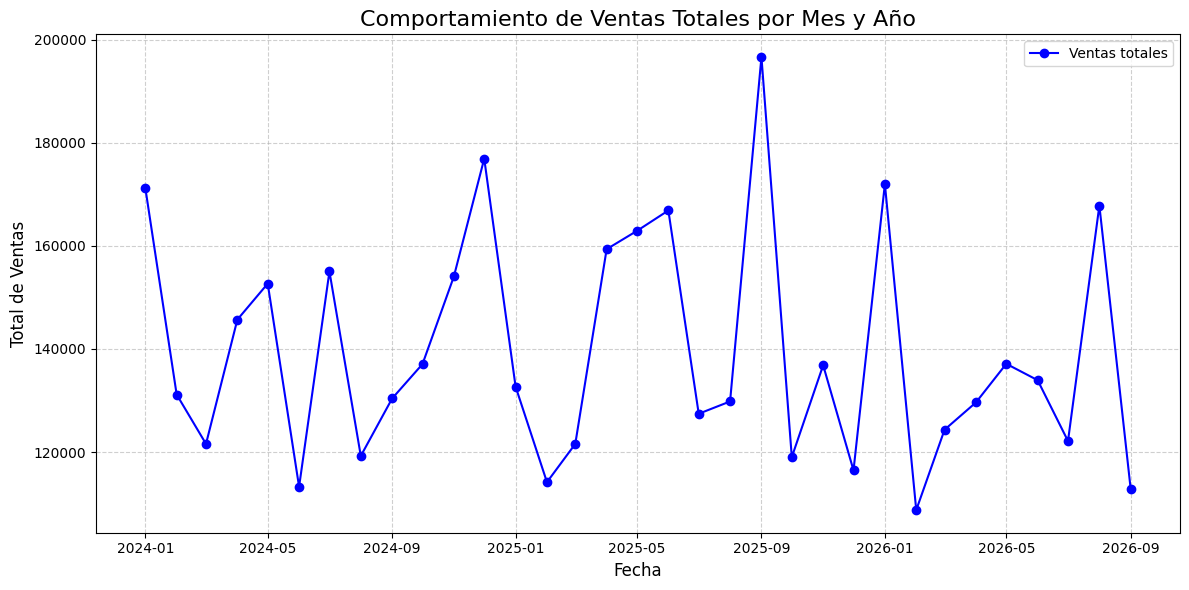

In [135]:
# Asegurar que la columna fecha_venta esté en formato datetime para facilitar su manejo
venta_df['fecha_venta'] = pd.to_datetime(venta_df['fecha_venta'])

# Unir los dataframes venta_df y venta_detalle_df para combinar datos de venta y sus detalles
ventas = venta_df.merge(venta_detalle_df, on='venta_id')

# Crear una columna anio_mes que combine el año y el mes de fecha_venta y convertirla a timestamp para graficar
ventas['anio_mes'] = ventas['fecha_venta'].dt.to_period('M').dt.to_timestamp()

# Agrupar los datos por anio_mes y sumar el total de ventas para cada periodo
ventas_mensuales = ventas.groupby('anio_mes')['total'].sum().reset_index()

# Configurar el gráfico para visualizar el comportamiento de las ventas mensuales a lo largo del tiempo
plt.figure(figsize=(12, 6))
plt.plot(ventas_mensuales['anio_mes'], ventas_mensuales['total'], marker='o', color='b', label='Ventas totales')
plt.title('Comportamiento de Ventas Totales por Mes y Año', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Total de Ventas', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

## Análisis Trimestral de Ventas por Categoría
### En este punto, se unen los dataframes venta_df, venta_detalle_df y categoria_df para obtener una vista combinada de las ventas. Posteriormente, los datos son agrupados por trimestre y categoría para analizar la evolución de las ventas en cada categoría. Finalmente, los resultados se grafican para visualizar los patrones de ventas a lo largo del tiempo.

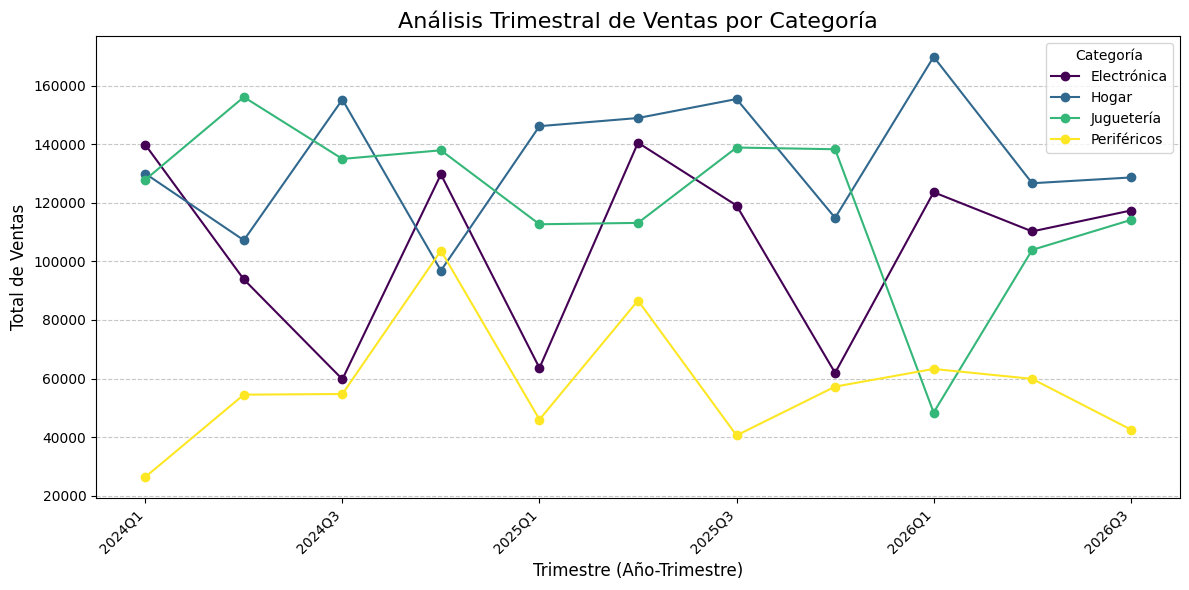

In [118]:
# Unir los dataframes venta_detalle, venta y categoria
ventas_detalladas = venta_detalle_df.merge(venta_df, on='venta_id').merge(categoria_df, on='categoria_id')

# (Opción para verificar que la columna nombre_categoria esté presente)
# print(ventas_detalladas.columns)

# Agregar columna de trimestre basada en fecha_venta
ventas_detalladas['trimestre'] = ventas_detalladas['fecha_venta'].dt.to_period('Q').astype(str)

# Agrupar por trimestre y nombre_categoria y sumar el total de ventas
ventas_por_trimestre_categoria = ventas_detalladas.groupby(['trimestre', 'nombre_categoria'])['total'].sum().reset_index()

# Pivotear el dataframe para que cada categoría tenga su propia columna
ventas_pivot_trimestral = ventas_por_trimestre_categoria.pivot(index='trimestre', columns='nombre_categoria', values='total')

# Crear y personalizar el gráfico de líneas para visualizar la evolución trimestral de ventas por categoría
ventas_pivot_trimestral.plot(kind='line', figsize=(12, 6), marker='o', colormap='viridis')
plt.title('Análisis Trimestral de Ventas por Categoría', fontsize=16)
plt.xlabel('Trimestre (Año-Trimestre)', fontsize=12)
plt.ylabel('Total de Ventas', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title='Categoría', fontsize=10)
plt.tight_layout()
plt.show()

## Análisis Trimestral de Ventas por Región
### Aquí se unen los dataframes venta_df, venta_detalle_df y region_df para obtener una vista combinada de las ventas. Los datos se agrupan por trimestre y región para analizar las ventas en cada región. Los resultados son graficados para visualizar los patrones de ventas a lo largo del tiempo.


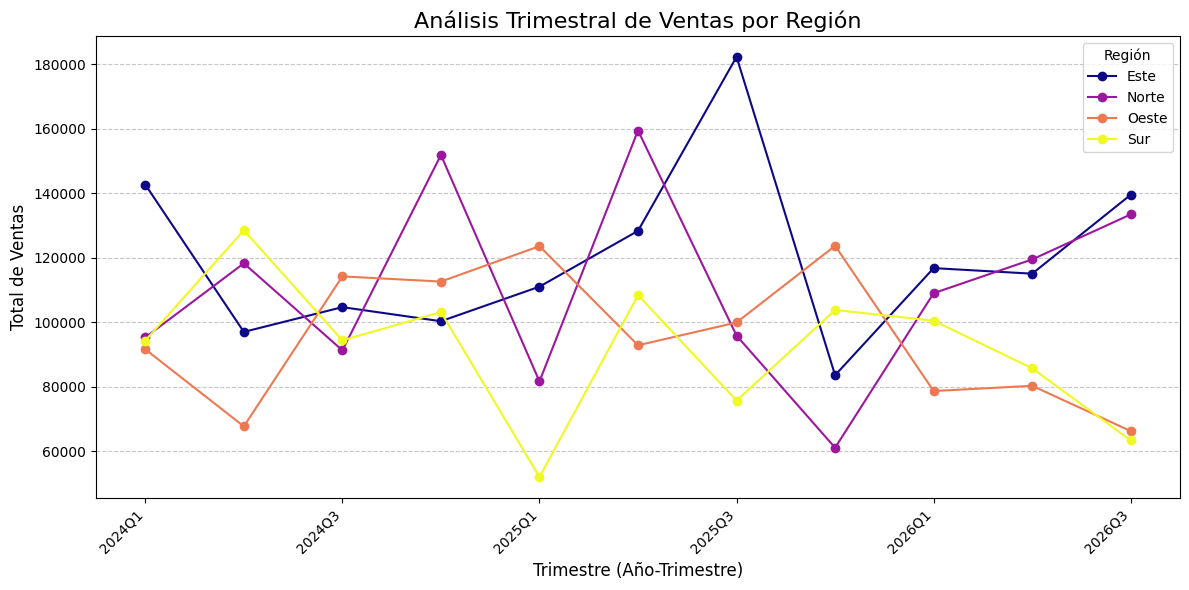

In [119]:
# Unir los dataframes venta_detalle_df, venta_df y region_df 
ventas_detalladas = venta_detalle_df.merge(venta_df, on='venta_id').merge(region_df, on='region_id')

# Agregar una columna con el trimestre basado en fecha_venta
ventas_detalladas['trimestre'] = ventas_detalladas['fecha_venta'].dt.to_period('Q').astype(str)

# Agrupar los datos por trimestre y nombre_region, y sumar el total de ventas
ventas_por_trimestre_region = ventas_detalladas.groupby(['trimestre', 'nombre_region'])['total'].sum().reset_index()

# Pivotear el dataframe para que cada región tenga su propia columna
ventas_pivot_trimestral_region = ventas_por_trimestre_region.pivot(index='trimestre', columns='nombre_region', values='total')

# Crear y personalizar el gráfico de líneas para visualizar la evolución trimestral de ventas por región
ventas_pivot_trimestral_region.plot(kind='line', figsize=(12, 6), marker='o', colormap='plasma')
plt.title('Análisis Trimestral de Ventas por Región', fontsize=16)
plt.xlabel('Trimestre (Año-Trimestre)', fontsize=12)
plt.ylabel('Total de Ventas', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title='Región', fontsize=10)
plt.tight_layout()
plt.show()

## Análisis de Ventas Totales por Categoría
### Aquí, los dataframes venta_detalle_df, venta_df y categoria_df se unen para obtener una vista combinada de las ventas. Los datos son agrupados por categoría para calcular el total de ventas y se crea una gráfica circular para visualizar la distribución de ventas por categoría.

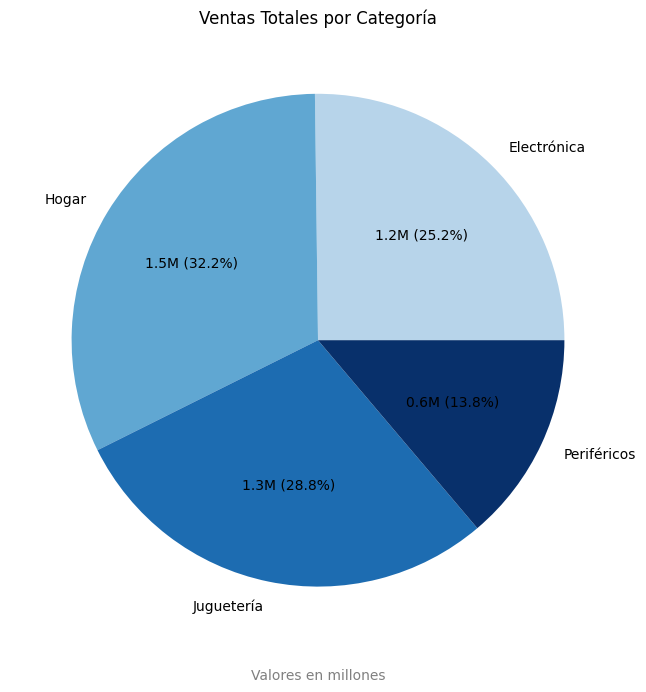

In [120]:
# Unir los dataframes venta_detalle_df, venta_df y categoria_df
ventas_detalladas = venta_detalle_df.merge(venta_df, on='venta_id').merge(categoria_df, on='categoria_id')

# Agrupar los datos por nombre_categoria y sumar el total de ventas por categoría
ventas_por_categoria = ventas_detalladas.groupby('nombre_categoria')['total'].sum()

# Crear una paleta de colores en degradado de azul
colors = plt.cm.Blues(np.linspace(0.3, 1, len(ventas_por_categoria)))

# Definir una función para mostrar el total y el porcentaje en la gráfica circular
def func(pct, allvals):
    absolute = np.round(pct / 100. * np.sum(allvals) / 1e6, 1) # Mostrar en millones 
    return f"{absolute}M ({pct:.1f}%)"

# Crear y personalizar la gráfica circular para visualizar la distribución de ventas por categoría 
plt.figure(figsize=(8, 8)) 
ventas_por_categoria.plot(kind='pie', figsize=(8, 8), autopct=lambda pct: func(pct, ventas_por_categoria), colors=colors, title='Ventas Totales por Categoría') 

# Eliminar la etiqueta del eje y para una mejor visualización 
plt.ylabel('') 
plt.annotate('Valores en millones', xy=(0.5, -0.05), xycoords='axes fraction', ha='center', fontsize=10, color='grey') 
plt.show()

## Análisis de Ventas Totales por Región
### Los dataframes venta_detalle_df, venta_df y region_df se unen para obtener una vista combinada de las ventas. Luego, los datos son agrupados por región para calcular el total de ventas y al final se crea una gráfica de barras para visualizar la distribución de ventas por región.

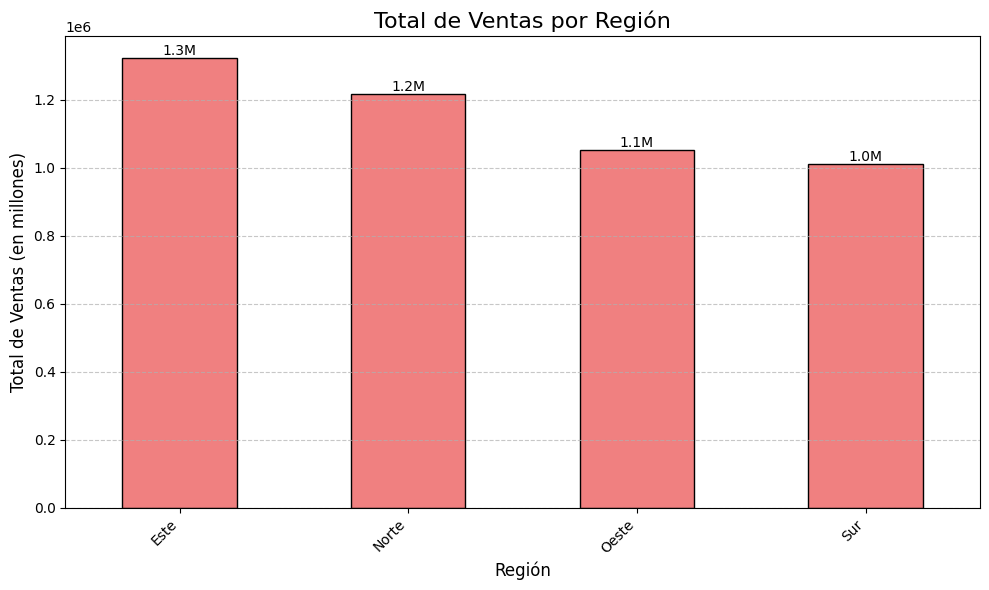

In [121]:
# Unir los dataframes venta_detalle_df, venta_df y region_df
ventas_detalladas = venta_detalle_df.merge(venta_df, on='venta_id').merge(region_df, on='region_id')

# Calcular el total de ventas por región y ordenar de mayor a menor
ventas_por_region = ventas_detalladas.groupby('nombre_region')['total'].sum().sort_values(ascending=False)

# Crear y personalizar la gráfica de barras para visualizar la distribución de ventas por región
plt.figure(figsize=(10, 6))
bars = ventas_por_region.plot(kind='bar', color='lightcoral', edgecolor='black')

# Agregar valores en la parte superior de las barras
for index, value in enumerate(ventas_por_region):
    plt.text(index, value, f"{value/1e6:.1f}M", ha='center', va='bottom', fontsize=10, color='black')  # Mostrar en millones

# Personalizar la gráfica
plt.title('Total de Ventas por Región', fontsize=16)
plt.xlabel('Región', fontsize=12)
plt.ylabel('Total de Ventas (en millones)', fontsize=12)  
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Correlación de Ventas por Categoría y Región
### Los dataframes venta_detalle_df, venta_df, categoria_df y region_df son unidos para obtener una vista combinada de las ventas. Los datos son agrupados por categoría y región para calcular el total de ventas. Se crea un gráfico de dispersión (scatter plot) para visualizar la correlación entre las ventas totales, las categorías y las regiones. El tamaño y el color de los puntos en el gráfico representan el total de ventas, y se añaden etiquetas para mostrar los valores en miles.


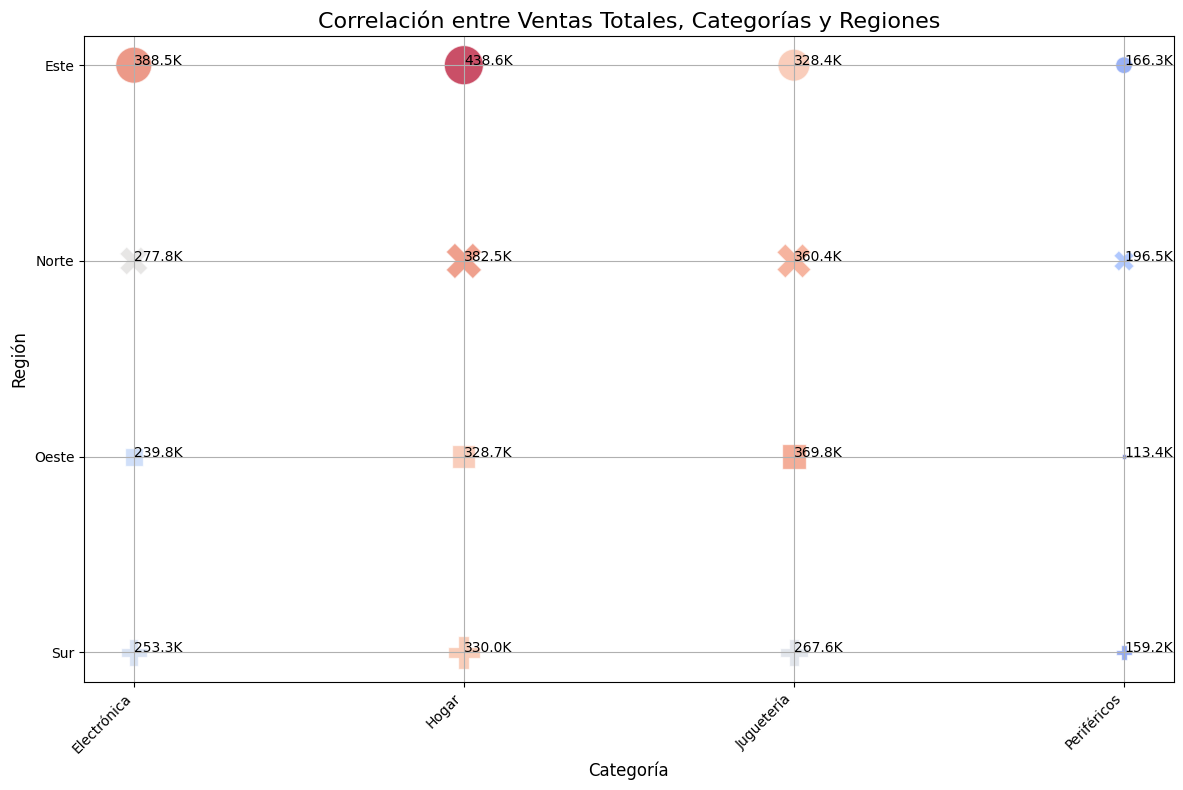

In [122]:
# Unir los dataframes venta_detalle_df, venta_df, categoria_df y region_df 
ventas_detalladas = venta_detalle_df.merge(venta_df, on='venta_id').merge(categoria_df, on='categoria_id').merge(region_df, on='region_id') 

# Agrupar los datos por nombre_categoria y nombre_region y sumar el total de ventas por combinación 
ventas_por_categoria_region = ventas_detalladas.groupby(['nombre_categoria', 'nombre_region'])['total'].sum().reset_index() 

# Crear y personalizar el gráfico de dispersión para visualizar la correlación entre ventas totales, categorías y regiones 
plt.figure(figsize=(12, 8)) 
sns.scatterplot(data=ventas_por_categoria_region, 
                x='nombre_categoria', 
                y='nombre_region', 
                size='total', # Usar el total de ventas para el tamaño del punto 
                hue='total', # Usar el total de ventas para el color de los puntos 
                palette='coolwarm', 
                sizes=(20, 800), # Tamaño mínimo y máximo de los puntos 
                alpha=0.7, # Transparencia de los puntos 
                style='nombre_region', # Usar diferentes marcadores para las regiones 
                legend=False) 

# Definir una función para formatear los valores en miles (con 'K')
def format_k(value): return f'{value/1000:.1f}K' 
    
# Añadir etiquetas de valores en el gráfico 
for line in range(ventas_por_categoria_region.shape[0]): 
    plt.text(ventas_por_categoria_region.nombre_categoria[line], 
             ventas_por_categoria_region.nombre_region[line], 
             format_k(ventas_por_categoria_region.total[line]), 
             horizontalalignment='left', size='medium', color='black', weight='regular') 
    
# Títulos y etiquetas del gráfico 
plt.title('Correlación entre Ventas Totales, Categorías y Regiones', fontsize=16) 
plt.xlabel('Categoría', fontsize=12) 
plt.ylabel('Región', fontsize=12) 
plt.xticks(rotation=45, ha='right', fontsize=10) 
plt.yticks(fontsize=10) 
plt.grid(True) 
plt.tight_layout() 
plt.show()

## Análisis de Ventas Totales por Producto
### Los dataframes venta_detalle_df, producto_df y venta_df son unidos para obtener una vista combinada de las ventas. Posteriormente, los datos son agrupados por producto para calcular el total de ventas y se crea una gráfica de dispersión para visualizar la relación entre los productos y las ventas totales.

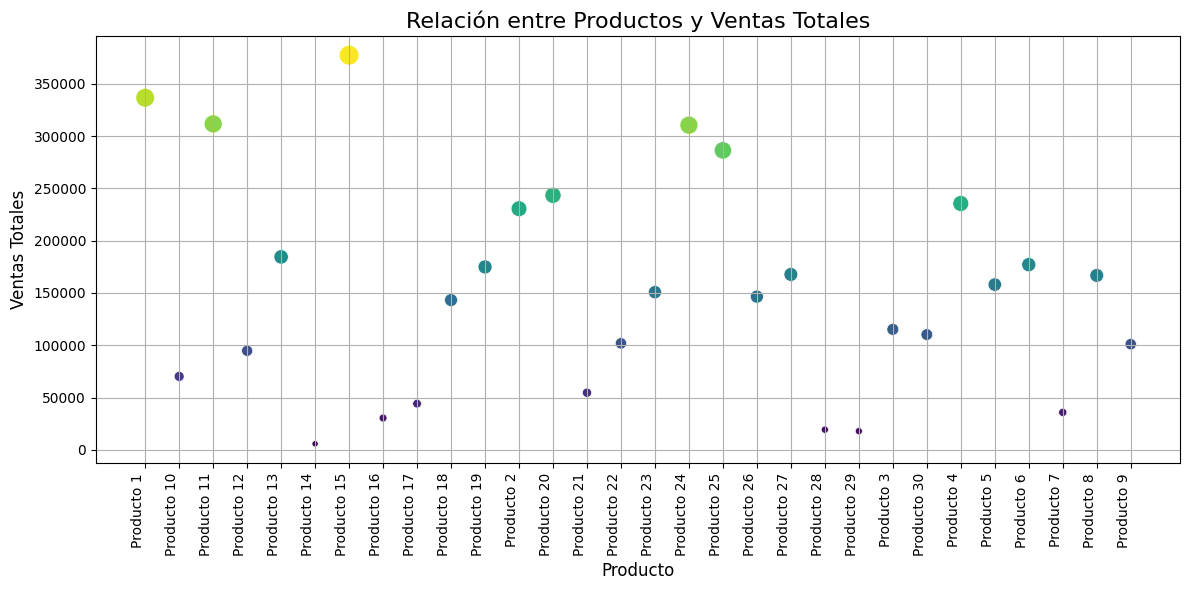

In [123]:
# Unir los dataframes venta_detalle_df, producto_df y venta_df
ventas_detalladas = venta_detalle_df.merge(producto_df, on='producto_id').merge(venta_df, on='venta_id')

# Agrupar los datos por nombre_producto y sumar el total de ventas por producto
ventas_por_producto = ventas_detalladas.groupby('nombre_producto')['total'].sum().reset_index()

# Crear y personalizar el gráfico de dispersión para visualizar la relación entre productos y ventas totales
plt.figure(figsize=(12, 6))
sns.scatterplot(data=ventas_por_producto, 
                x='nombre_producto', 
                y='total',  # Total de ventas por producto
                size='total',  # Usar el total de ventas para el tamaño del punto
                hue='total',   # Usar el total de ventas para el color de los puntos
                palette='viridis',  
                sizes=(20, 200),    # Tamaño mínimo y máximo de los puntos
                legend=False)

# Personalizar y mostrar la gráfica
plt.title('Relación entre Productos y Ventas Totales', fontsize=16)
plt.xlabel('Producto', fontsize=12)
plt.ylabel('Ventas Totales', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True) 
plt.tight_layout()
plt.show()

## Productos Más Vendidos
### Se agrupan las ventas detalladas por producto y se calcula la cantidad total vendida de cada producto. Posteriormente, se unen los datos con el dataframe producto_df para obtener los nombres de los productos. Finalmente, se crea una gráfica de barras para visualizar los 10 productos más vendidos.

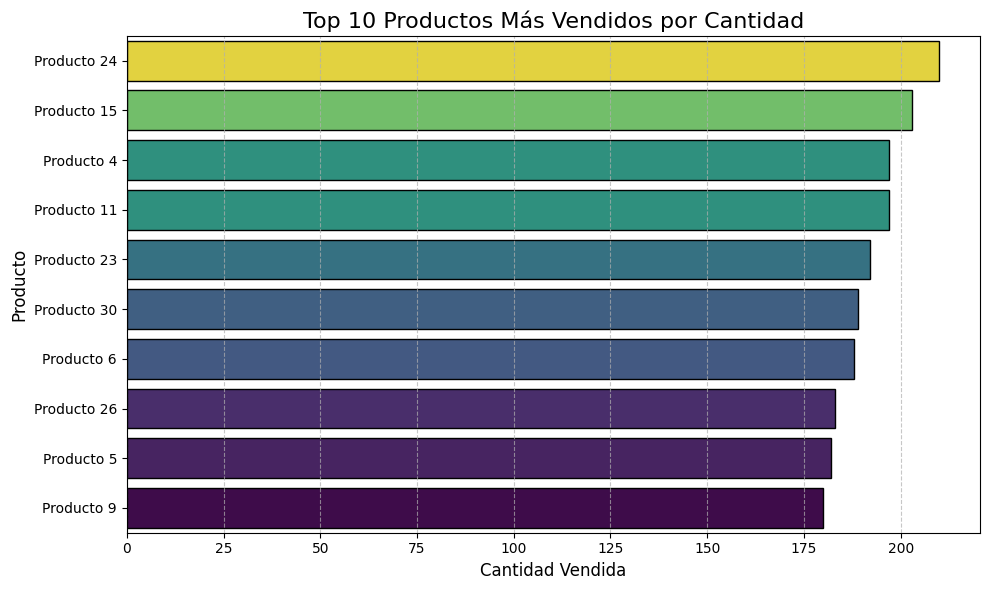

In [124]:
# Agrupar las ventas detalladas por producto y calcular la cantidad total vendida de cada producto
productos_vendidos = venta_detalle_df.groupby('producto_id')['cantidad'].sum().reset_index()

# Unir los datos de productos vendidos con la tabla de productos para obtener los nombres de los productos
productos_vendidos = productos_vendidos.merge(producto_df[['producto_id', 'nombre_producto']], on='producto_id')

# Crear y personalizar la gráfica de barras para visualizar los 10 productos más vendidos por cantidad
plt.figure(figsize=(10, 6))
sns.barplot(x='cantidad', y='nombre_producto', data=productos_vendidos.sort_values('cantidad', ascending=False).head(10), hue='cantidad',palette='viridis', edgecolor='black',legend=False)
plt.title('Top 10 Productos Más Vendidos por Cantidad', fontsize=16)
plt.xlabel('Cantidad Vendida', fontsize=12)
plt.ylabel('Producto', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Ranking de Productos por Ventas Totales
### Se unen los dataframes venta_detalle_df y producto_df para obtener una vista combinada de las ventas. Luego, se calcula el total de ventas por producto multiplicando la cantidad vendida por el precio unitario. Posteriormente, se agrupan los datos por producto para sumar el total de ventas. Se obtienen los 10 productos con el mayor total de ventas y se unen con el dataframe producto_df para obtener los nombres de los productos. Finalmente, se muestra el ranking de los productos por total de ventas.

In [125]:
# Unir los dataframes venta_detalle_df y producto_df 
ventas_detalladas = venta_detalle_df.merge(producto_df, on='producto_id')

# Agrupar los datos por producto_id y sumar el total de ventas por producto
ventas_totales_por_producto = ventas_detalladas.groupby('producto_id')['total'].sum().reset_index()

# Obtener los 10 productos con mayor total de ventas
productos_ranking = ventas_totales_por_producto.nlargest(10, 'total')

# Unir con la tabla de productos para obtener el nombre del producto
productos_ranking = productos_ranking.merge(producto_df[['producto_id', 'nombre_producto']], on='producto_id')

# Convertir el total de ventas a miles para una mejor legibilidad 
productos_ranking['total'] = productos_ranking['total'] / 1e3 
productos_ranking['total'] = productos_ranking['total'].round(2) 

# Añadir una columna de ranking 
productos_ranking['ranking'] = range(1, len(productos_ranking) + 1) 

# Mostrar el ranking de productos por total de ventas 
print(productos_ranking[['ranking', 'nombre_producto', 'total']])

   ranking nombre_producto   total
0        1     Producto 15  377.21
1        2      Producto 1  336.61
2        3     Producto 11  311.59
3        4     Producto 24  310.38
4        5     Producto 25  286.26
5        6     Producto 20  243.34
6        7      Producto 4  235.50
7        8      Producto 2  230.51
8        9     Producto 13  184.43
9       10      Producto 6  176.99


## Gráfico de Pareto de Ventas por Producto
### Los dataframes venta_detalle_df, producto_df y venta_df se unen para obtener una vista combinada de las ventas. Luego, se agrupan los datos por producto para calcular el total de ventas. Se ordenan los productos de mayor a menor total de ventas y se calcula el porcentaje acumulado. Al final, se crea un gráfico de Pareto que combina una gráfica de barras para el total de ventas por producto y una gráfica de línea para el porcentaje acumulado, permitiendo visualizar la importancia relativa de cada producto en el total de ventas.

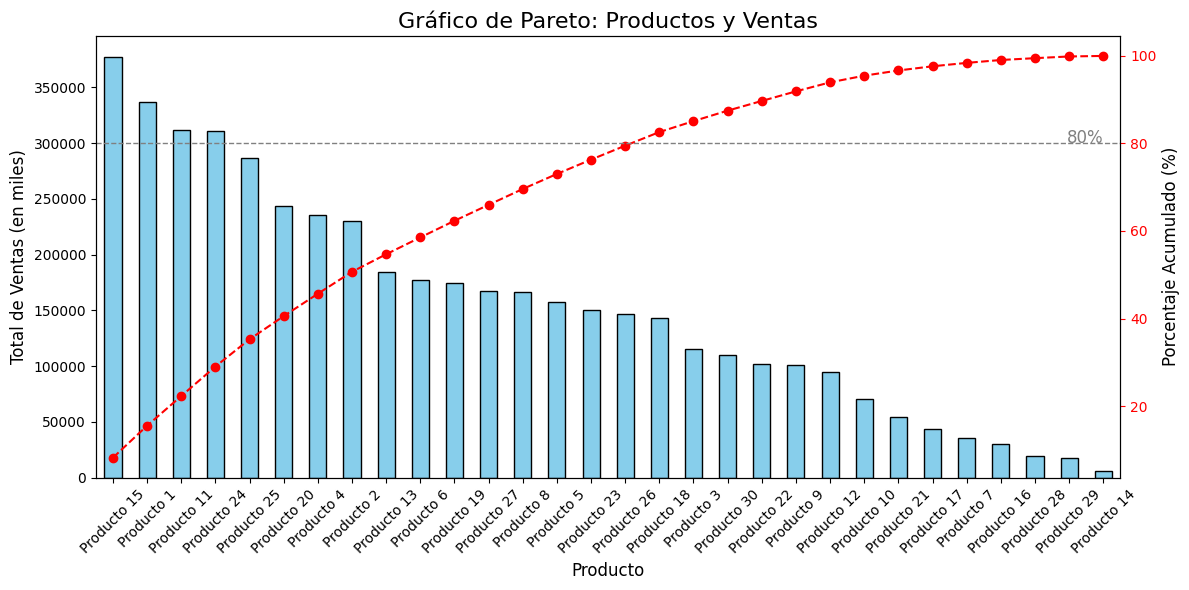

In [126]:
# Unir los dataframes venta_detalle_df, producto_df y venta_df 
ventas_detalladas = venta_detalle_df.merge(producto_df, on='producto_id').merge(venta_df, on='venta_id')

# Agrupar los datos por nombre_producto y sumar el total de ventas por producto
ventas_por_producto = ventas_detalladas.groupby('nombre_producto')['total'].sum().sort_values(ascending=False)

# Calcular el porcentaje acumulado
porcentaje_acumulado = ventas_por_producto.cumsum() / ventas_por_producto.sum() * 100

# Crear y personalizar el gráfico de Pareto
fig, ax1 = plt.subplots(figsize=(12, 6))

# Gráfica de barras para el total de ventas por producto
ventas_por_producto.plot(kind='bar', color='skyblue', edgecolor='black', ax=ax1)
ax1.set_ylabel('Total de Ventas (en miles)', fontsize=12)
ax1.set_xlabel('Producto', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.set_title('Gráfico de Pareto: Productos y Ventas', fontsize=16)

# Gráfica de línea para el porcentaje acumulado
ax2 = ax1.twinx()
ax2.plot(porcentaje_acumulado, color='red', marker='o', linestyle='--')
ax2.set_ylabel('Porcentaje Acumulado (%)', fontsize=12)
ax2.tick_params(axis='y', colors='red')

# Agregar línea horizontal al 80%
ax2.axhline(80, color='gray', linestyle='--', linewidth=1)
ax2.text(len(porcentaje_acumulado) - 1, 80, '80%', color='gray', fontsize=12, ha='right')

plt.tight_layout()
plt.show()


## Distribución de Ventas Totales
### Se extraen los datos de la columna total del dataframe venta_detalle_df para luego crear un histograma para visualizar la distribución de las ventas totales. 

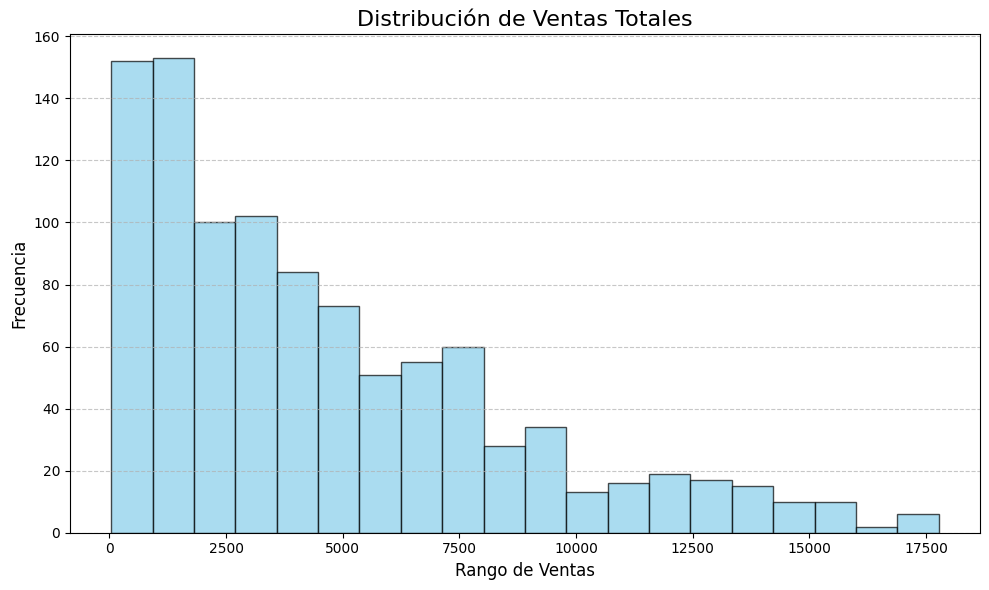

In [127]:
# Extraer los datos de ventas (columna 'total')
ventas_totales = venta_detalle_df["total"]

# Crear y personalizar el histograma para visualizar la distribución de ventas totales
plt.figure(figsize=(10, 6))
plt.hist(ventas_totales, bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Personalizar la gráfica
plt.title('Distribución de Ventas Totales', fontsize=16)
plt.xlabel('Rango de Ventas', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Análisis de Ventas por Categoría
### Se unen venta_detalle_df, venta_df y categoria_df para obtener una vista combinada de las ventas. Se agrupan los datos por categoría para calcular la cantidad de ventas y el total de ventas por categoría. Los resultados se presentan en una gráfica combinada que utiliza barras para mostrar la cantidad de ventas y líneas para mostrar el total de ventas, permitiendo una visualización clara de ambos aspectos en una misma gráfica.

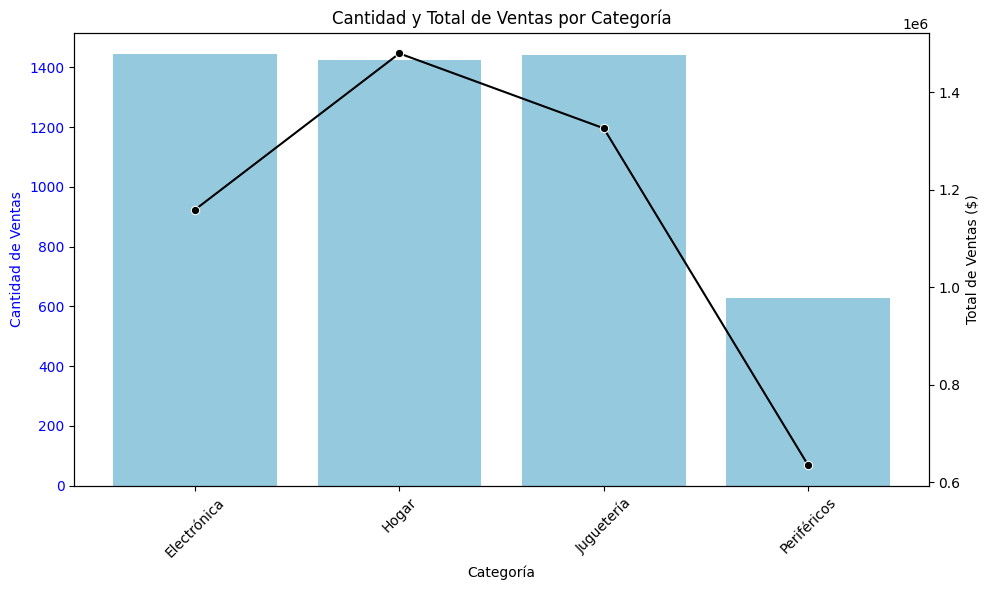

In [131]:
# Unir los dataframes venta_detalle_df, venta_df y categoria_df
ventas_detalladas = venta_detalle_df.merge(venta_df, on='venta_id').merge(categoria_df, on='categoria_id')

# Agrupar los datos por nombre_categoria para calcular la cantidad de ventas y el total de ventas por categoría
ventas_por_categoria = ventas_detalladas.groupby('nombre_categoria').agg(
    cantidad_ventas=('cantidad', 'sum'),
    total_ventas=('total', 'sum')
).reset_index()

# --- Gráfica combinada para Categoría ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# Gráfica de barras para la cantidad de ventas por categoría
sns.barplot(
    x='nombre_categoria',
    y='cantidad_ventas',
    data=ventas_por_categoria,
    color='skyblue',
    ax=ax1
)
ax1.set_ylabel('Cantidad de Ventas', color='blue')
ax1.set_xlabel('Categoría')
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='y', labelcolor='blue')

# Gráfica de líneas para el total de ventas por categoría
ax2 = ax1.twinx()
sns.lineplot(
    x='nombre_categoria',
    y='total_ventas',
    data=ventas_por_categoria,
    color='black',
    marker='o',
    ax=ax2
)
ax2.set_ylabel('Total de Ventas ($)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

plt.title('Cantidad y Total de Ventas por Categoría')
plt.tight_layout()
plt.show()

## Análisis de Ventas por Región
### Se unen venta_detalle_df, venta_df y region_df para obtener una vista combinada de las ventas. Luego, se agrupan los datos por región para calcular la cantidad de ventas y el total de ventas por región. Los resultados se presentan en una gráfica combinada de barras y líneas para visualizar tanto la cantidad como el total de ventas por región al mismo tiempo.

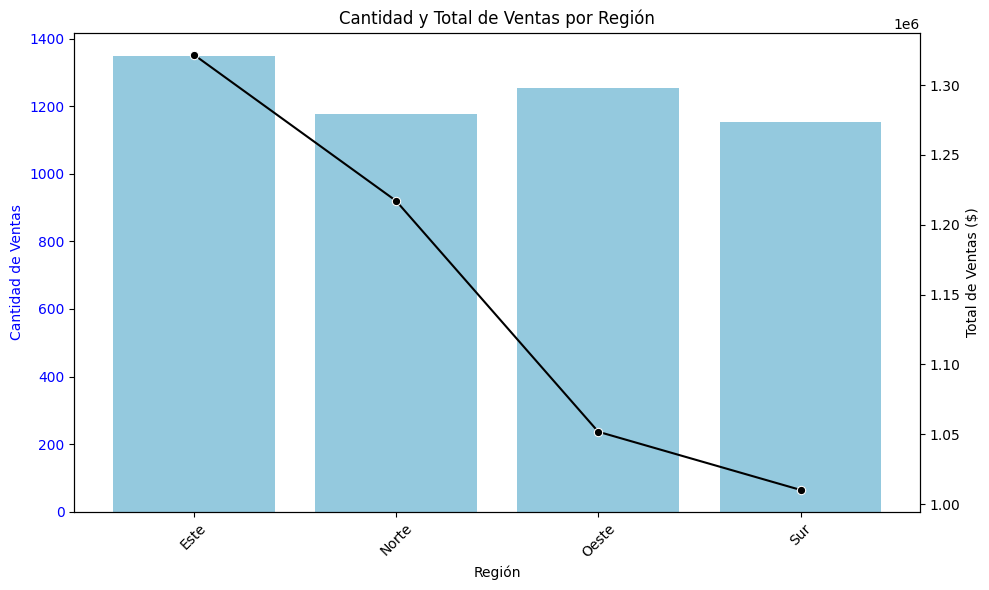

In [132]:
# Unir venta_detalle_df, venta_df y region_df
ventas_detalladas = venta_detalle_df.merge(venta_df, on='venta_id').merge(region_df, on='region_id')

# Agrupar los datos por nombre_region para calcular la cantidad de ventas y el total de ventas por región
ventas_por_region = ventas_detalladas.groupby('nombre_region').agg(
    cantidad_ventas=('cantidad', 'sum'),
    total_ventas=('total', 'sum')
).reset_index()

# --- Gráfica combinada para Región ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# Gráfica de barras para la cantidad de ventas por región
sns.barplot(
    x='nombre_region',
    y='cantidad_ventas',
    data=ventas_por_region,
    color='skyblue',
    ax=ax1
)
ax1.set_ylabel('Cantidad de Ventas', color='blue')
ax1.set_xlabel('Región')
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='y', labelcolor='blue')

# Gráfica de líneas para el total de ventas por región
ax2 = ax1.twinx()
sns.lineplot(
    x='nombre_region',
    y='total_ventas',
    data=ventas_por_region,
    color='black',
    marker='o',
    ax=ax2
)
ax2.set_ylabel('Total de Ventas ($)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Personalización del título y ajuste del diseño del gráfico
plt.title('Cantidad y Total de Ventas por Región')
plt.tight_layout()
plt.show()

##  Segmentación de Clientes por Comportamiento de Compra
### Se agrega el total de ventas por cliente, se agrupan los clientes usando KMeans y se visualizan los segmentos resultantes.

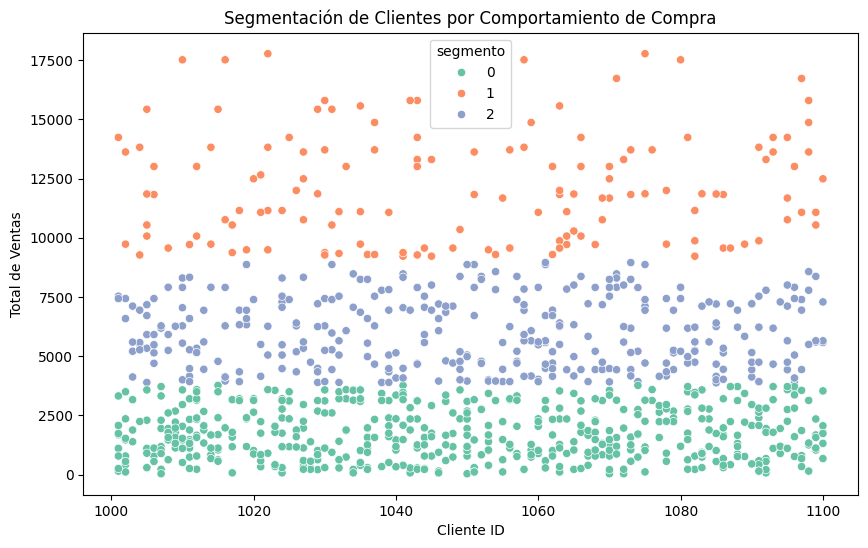

In [133]:
# Calcular el total de ventas por cliente
ventas_por_cliente = venta_detalle_df.groupby('venta_id')['total'].sum().reset_index()

# Unir ventas_por_cliente y venta_df para obtener cliente_id
ventas_por_cliente = ventas_por_cliente.merge(venta_df[['venta_id', 'cliente_id']], on='venta_id')

# Agrupar los clientes utilizando KMeans con 3 clústeres
kmeans = KMeans(n_clusters=3, random_state=42)
ventas_por_cliente['segmento'] = kmeans.fit_predict(ventas_por_cliente[['total']])

# Visualizar los segmentos de clientes
plt.figure(figsize=(10, 6))
sns.scatterplot(x='cliente_id', y='total', hue='segmento', data=ventas_por_cliente, palette='Set2')
plt.title('Segmentación de Clientes por Comportamiento de Compra')
plt.xlabel('Cliente ID')
plt.ylabel('Total de Ventas')
plt.show()

## Mapa de Calor de Correlación entre Variables
### Se crea un mapa de calor para visualizar las correlaciones entre las variables del dataframe venta_detalle_df

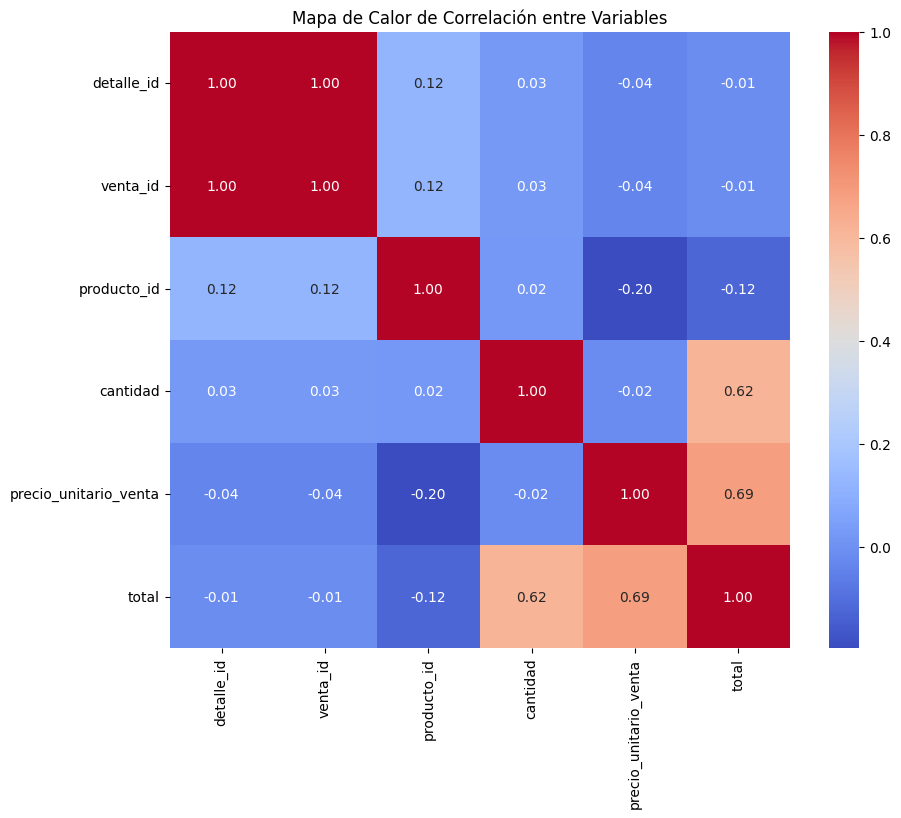

In [134]:
# Calcular la matriz de correlación 
correlation_matrix = venta_detalle_df.corr() 

# Crear y personalizar el mapa de calor para visualizar la matriz de correlación 
plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f') 
plt.title('Mapa de Calor de Correlación entre Variables')
plt.show()